## Problem 7.16

This problem reproduces the global-element version of Problem 7.14 for a cooling half-space, using a local element method. We introduced the local-element method for the diffusivity matrix in Problem 7.10. Similarly, the timestepping component was introduced in Problem 7.14. The details are therefore not re-capitulated here. 

The new component introduced in this problem is the assembly of the capacity matrix from local elements. 

In the hidden cell below, we will set up the domain and initial conditions in an identical manner to Problem 7.14.

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import scipy.special as ss 

## Domain setup: 
L       = 20        # Domain size
alpha   = 1         # Diffusivity

nelem   = 1000      # Elements
npts    = nelem + 1 # Control points

eta     = 0.5       # Time scheme param.
dt      = 0.05      # Time step

# Define grid points of domain
# and grid spacing 
# Note LHS is defined as L where
# Neumann condition exists
# and RHS (z=0) for Dirichlet BC
z = np.linspace(L, 0, npts)
dz =  z[:-1] - z[1:]

# Initial condition:
analytical = np.zeros(npts)
temp       = np.zeros(npts)

# assume initial dtemp/dt = 0
dtemp_dt = np.zeros(npts)

# zero only at surface
analytical[:-1] = 1
temp[:-1]       = 1

/usr/local/Caskroom/miniconda/base/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Next, the global capacity and diffusivity matrices are assembled from local elements: 

In [2]:
# Generate Global K & M matrices
M = np.zeros((nelem, nelem))
K = np.zeros((nelem, nelem))

# loop over elements 
for ielem in range(nelem):

    # Compute local diffusivity matrix 
    # for this element using 7.65
    kloc = np.zeros((2,2))
    kloc[0,0] = 1
    kloc[1,1] = 1
    kloc[0,1] = -1
    kloc[1,0] = -1
    kloc *= (1/dz[ielem])
    
    # Compute local capacity matrix: 
    # Eqn. 7.106
    mloc = np.zeros((2,2))
    mloc[0,0] = 2
    mloc[1,1] = 2
    mloc[0,1] = 1
    mloc[1,0] = 1
    mloc *= dz[ielem]/6

    
    # Assemble the K and M matrices
    if ielem == nelem -1: 
        # For the last element we are ignoring the 
        #contributions from the n + 1 node 
        K[ielem, ielem] += kloc[0,0]
        M[ielem, ielem] += mloc[0,0]
    else:
        K[ielem:ielem+2, ielem:ielem+2] += kloc
        M[ielem:ielem+2, ielem:ielem+2] += mloc
    


Finally, we can conduct timestepping in a similar manner to Problem 7.14 and reproduce the results:

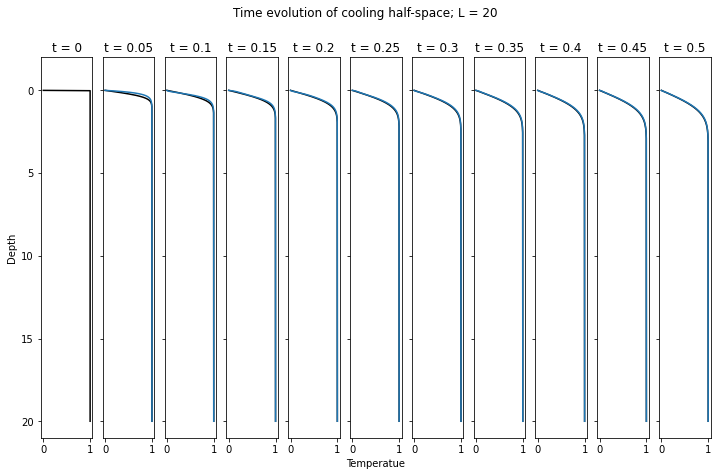

In [3]:
# Inverse of [M + eta \delta t K]
MKinv = np.linalg.inv(M + eta*dt*K)

# Create plots of time evolution
fig, ax = plt.subplots(1, 11, 
                       sharey=True, 
                       figsize=(12,7))


# Step in time 
time = 0

# Plot initial condition 
ax[0].plot(temp, z, 'k')

for istep in range(10):
    # Compute time 
    time += dt

    # Compute analytical solution
    argument = z / (2 * np.sqrt(alpha * time))
    analytical = ss.erf(argument)
    ax[1+istep].plot(analytical, z, 'k')

    # --- FEM calculation ---
    # Predictor:
    dtilde = temp[:-1] + (1-eta)* dt * dtemp_dt[:-1]

    # Solve for dtemp_dt at next timestep
    dtemp_dt[:-1] = np.matmul(MKinv,  - np.matmul(K, dtilde))

    # Corrector:
    temp[:-1] = dtilde + (eta * dt * dtemp_dt[:-1])

    ax[istep+1].set_title(f"t = {np.around(time,2)}");

    ax[istep+1].plot(temp, z)
    
    
# Some plot formatting 
ax[0].set_ylim([21, -0.1*L]);
ax[0].set_title(f"t = 0");
fig.suptitle(f"Time evolution of cooling half-space; L = {L}");
ax[0].set_ylabel("Depth");
ax[5].set_xlabel("Temperatue");